In [206]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# 加载数据集


In [207]:
def prepareData():
    
    # 读入预处理的数据
    datas = np.load("tang.npz", allow_pickle=True)
    data = datas['data']
    ix2word = datas['ix2word'].item()
    word2ix = datas['word2ix'].item()
    
    # 转为torch.Tensor
    data = torch.from_numpy(data)
    dataloader = DataLoader(data,
                         batch_size = 32,
                         shuffle = True,
                         num_workers = 0)
    
    return dataloader, ix2word, word2ix

In [208]:
dataloader, ix2word, word2ix = prepareData()

# 构建模型

模型包括Embedding层、LSTM层和输出层。

In [216]:
class PoetryModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(PoetryModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_dim, num_layers=2)
        self.linear = nn.Linear(self.hidden_dim, vocab_size)

    def forward(self, input, hidden = None):
        seq_len, batch_size = input.size()
        
        if hidden is None:
            h_0 = input.data.new(2, batch_size, self.hidden_dim).fill_(0).float()
            c_0 = input.data.new(2, batch_size, self.hidden_dim).fill_(0).float()
        else:
            h_0, c_0 = hidden

        embeds = self.embedding(input)
        output, hidden = self.lstm(embeds, (h_0, c_0))
        output = self.linear(output.view(seq_len * batch_size, -1))
        return output, hidden

# 训练模型

In [217]:
# 设置超参数
learning_rate = 5e-3       # 学习率
embedding_dim = 128        # 嵌入层维度
hidden_dim = 256           # 隐藏层维度
model_path = None          # 预训练模型路径
epochs = 4                 # 训练轮数
verbose = True             # 打印训练过程
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [218]:
def train(dataloader, ix2word, word2ix):
    model = PoetryModel(len(word2ix), embedding_dim, hidden_dim)
    if model_path:
        model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    loss_list = []
    batch_count = 0

    for epoch in range(epochs):
        for batch_idx, data in enumerate(dataloader):
            data = data.long().transpose(1, 0).contiguous().to(device)
            input, target = data[:-1, :], data[1:, :]

            output, _ = model(input)
            output = output.view(-1, output.size(-1))  # flatten logits
            target = target.contiguous().view(-1)      # flatten labels

            loss = criterion(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())
            batch_count += 1

            if batch_idx % 900 == 0 and verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data[1]), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))

    torch.save(model.state_dict(), 'model.pth')

    # 绘制 loss 曲线
    plt.figure(figsize=(10, 5))
    plt.plot(loss_list, label='Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('loss_curve.png')
    plt.show()


Train Epoch: 1 [0/57580 (0%)]	Loss: 8.992303
Train Epoch: 1 [28800/57580 (50%)]	Loss: 2.669371
Train Epoch: 2 [0/57580 (0%)]	Loss: 2.288157
Train Epoch: 2 [28800/57580 (50%)]	Loss: 1.862764
Train Epoch: 3 [0/57580 (0%)]	Loss: 2.022201
Train Epoch: 3 [28800/57580 (50%)]	Loss: 2.178975
Train Epoch: 4 [0/57580 (0%)]	Loss: 2.164243
Train Epoch: 4 [28800/57580 (50%)]	Loss: 2.214765


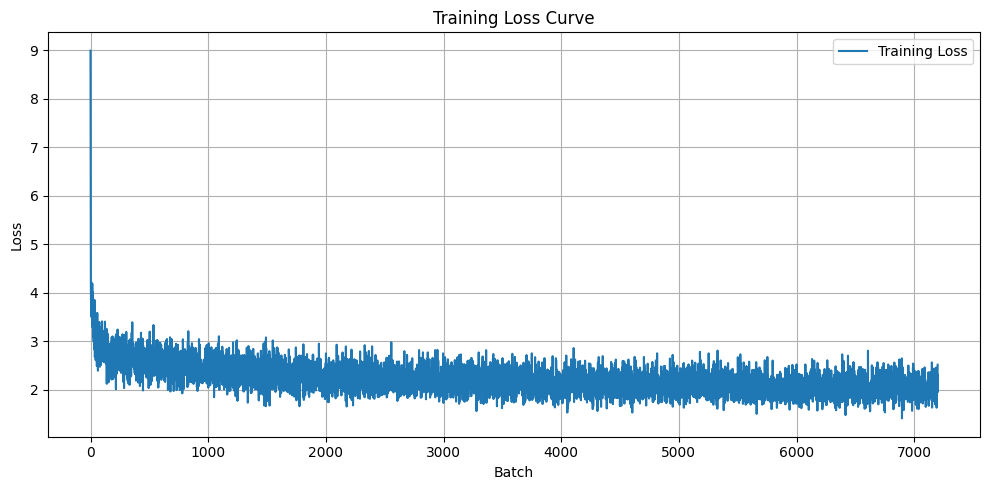

In [219]:
train(dataloader, ix2word, word2ix)

# 生成唐诗

给定几个词，根据这几个词接着生成一首完整的唐诗。

In [220]:
# 设置超参数
model_path = 'model.pth'        # 模型路径
start_words = '湖光秋月两相和'  # 唐诗的第一句
max_gen_len = 125                # 生成唐诗的最长长度

In [221]:
def generate_tang(start_words, ix2word, word2ix):

    # 读取模型
    model = PoetryModel(len(word2ix), embedding_dim, hidden_dim)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    
    # 读取唐诗的第一句
    results = list(start_words)
    start_word_len = len(start_words)
    
    # 设置第一个词为<START>
    input = torch.Tensor([word2ix['<START>']]).view(1, 1).long()
    input = input.to(device)
    hidden = None

    # 生成唐诗
    for i in range(max_gen_len):
        output, hidden = model(input, hidden)
        # 读取第一句
        if i < start_word_len:
            w = results[i]
            input = input.data.new([word2ix[w]]).view(1, 1)
        # 生成后面的句子
        else:
            top_index = output.data[0].topk(1)[1][0].item()
            w = ix2word[top_index]
            results.append(w)
            input = input.data.new([top_index]).view(1, 1)
        # 结束标志
        if w == '<EOP>':
            del results[-1]
            break
            
    return results

In [222]:
results = generate_tang(start_words, ix2word, word2ix)

def format_to_qijue_poem(char_list):
    # 过滤掉标点符号，以保证每句刚好7个字
    filtered_chars = [char for char in char_list if char not in {'，', '。'}]

    # 将字每7个一组
    lines = [''.join(filtered_chars[i:i+7]) for i in range(0, len(filtered_chars), 7)]

    # 添加标点：逢偶数句加“。”，奇数句加“，”
    formatted_poem = []
    for i, line in enumerate(lines):
        if len(line) < 7:
            continue  # 丢弃不完整句
        punctuation = '，' if i % 2 == 0 else '。'
        formatted_poem.append(line + punctuation)

    return '\n'.join(formatted_poem)

print(format_to_qijue_poem(results))

湖光秋月两相和，
一声一声秋草绿。
一声声断秋风起，
夜夜夜啼秋月明。
君不见君王不见，
君不见君王不可。
见一声一声不可，
见一声声急无人。
语君不见君王不，
知不知不知不得。
知一朝不见长安，
道一笑不知何所。
之君不见君王不，
见不知不知不得。


C:\Users\19108\AppData\Local\Temp\ipykernel_13772\254178465.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


# 生成藏头诗



In [223]:
# 设置超参数
model_path = 'model.pth'                 # 模型路径
start_words_acrostic = '湖光秋月两相和'  # 唐诗的“头”
max_gen_len_acrostic = 125               # 生成唐诗的最长长度

In [224]:
def generate_cang(start_words, ix2word, word2ix):

    # 读取模型
    model = PoetryModel(len(word2ix), embedding_dim, hidden_dim)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    
    # 读取唐诗的“头”
    results = []
    start_word_len = len(start_words)
    
    # 设置第一个词为<START>
    input = (torch.Tensor([word2ix['<START>']]).view(1, 1).long())
    input = input.to(device)
    hidden = None

    index = 0            # 指示已生成了多少句
    pre_word = '<START>' # 上一个词

    # 生成藏头诗
    for i in range(max_gen_len_acrostic):
        output, hidden = model(input, hidden)
        top_index = output.data[0].topk(1)[1][0].item()
        w = ix2word[top_index]

        # 如果遇到标志一句的结尾，喂入下一个“头”
        if (pre_word in {u'。', u'！', '<START>'}):
            # 如果生成的诗已经包含全部“头”，则结束
            if index == start_word_len:
                break
            # 把“头”作为输入喂入模型
            else:
                w = start_words[index]
                index += 1
                input = (input.data.new([word2ix[w]])).view(1, 1)
                
        # 否则，把上一次预测作为下一个词输入
        else:
            input = (input.data.new([word2ix[w]])).view(1, 1)
        results.append(w)
        pre_word = w
        
    return results

In [225]:
results_acrostic = generate_cang(start_words_acrostic, ix2word, word2ix)
def format_cangtou_poem(results, start_words):
    sentences = []
    sentence = []

    # 分句（遇到“，”或“。”就切句）
    for word in results:
        sentence.append(word)
        if word in {'，', '。'}:
            sentences.append(''.join(sentence))
            sentence = []

    # 校验
    if len(sentences) < len(start_words):
        print("生成的句子数不足，不能形成完整的藏头诗")
        return ""

    # 强制保留前 len(start_words) 句作为藏头诗
    cangtou_poem = []
    for i, head in enumerate(start_words):
        line = sentences[i]
        if not line.startswith(head):
            # 若开头字不是藏头字，强行替换第一字
            line = head + line[1:]
        cangtou_poem.append(line)

    return '\n'.join(cangtou_poem)

print(format_cangtou_poem(results_acrostic,start_words_acrostic))

湖上春风起，
光风吹落晖。
秋辉如有意，
月景亦无穷。
两草生寒色，
相风动夕阳。
和明春草绿，


C:\Users\19108\AppData\Local\Temp\ipykernel_13772\678109101.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
